# Fishtest SPRT optimization

The goal of this study is to estimate the impact of changes to the SPRT bounds on the testing procedure as implemented on fishtest. In particular, can it be avoided to apply micro-elo gaining patches, while at the same time accepting as many as possible of the real elo-gaining patches. All of this, keeping an eye on the cost of testing. 

### Background

The current framework uses [0,5] SPRT bounds both at STC (10+0.1) and LTC (60+0.6). SF9 - SF10 needed roughly 85 elo gaining patches to gain roughly 50 Elo. To find those ~15000 patches were tested. So average value of an applied patch is relatively low, and fishtest might be not tuned to this.

### Summary

After extensive testing, I propose new bounds [1,4]@STC(10+0.1) and [0,3]@LTC(60+0.6). These bounds significantly reduce (5x) the probability to pass 0 Elo patches, while improving at the same time the probability to pass 1 or 2 Elo patches by 35-20%. The number of patches applied as well as the Elo gained is expected to increase by 30%. The testing resources needed increase by roughly 2x, assuming the number of patches tested remains the same.


In [1]:
from pylab import *
from sprta import SPRT, scale

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }  

<IPython.core.display.Javascript object>

## Basic SPRT definitions
as obtained from the tools provided by Michel Van den Bergh.

In [3]:
def sprt_pass_prob(x, draw_elo, elo0, elo1, conf):
    """pass probability for a patch of x logistic elo, given drawElo, sprt bayesElo bounds and confidence p value"""
    s=SPRT(conf,conf,elo0,elo1,draw_elo)
    delo=x/scale(draw_elo)
    (power,expected)=s.characteristics(delo)
    return power

def sprt_cost(x, draw_elo, elo0, elo1, conf):
    """expect number of games needed for a test for a patch of x logistic elo, given drawElo, sprt bayesElo bounds and confidence p value"""
    s=SPRT(conf,conf,elo0,elo1,draw_elo)
    delo=x/scale(draw_elo)
    (power,expected)=s.characteristics(delo)
    return expected

## Fishtest patch models

In order to make predictions on the possible cost / effectiveness of a new testing scheme, some assumption is needed on the kind of patches that are being submitted to fishtest. The measurement of the distribution of fishtest STC patches is available: ![FishtestEloDist](stc_tests_elo.png)

We assume some a simple model Gaussian model for the distribution of created patches, matching the above data near zero Elo [The precise shape of the distribution doesn't really matter for tests with high (> ~5 Elo) or low (< ~0 Elo)]. Obviously fishtest is dynamic, and people adjust to e.g. available resources, ideas, etc. So, while we can't predict the future, this is a reasonable model of the recent past.

In all what follows we assume that the logistic Elo value of a patch is constant with TC (which obviously is an approximation).

In [4]:
def patch_elo_dist(x):
    #fishtest model
    sigma = 0.85
    mu = 0.56
    #Marco suggestion
    sigma = 1.112
    mu = -0.21
    return exp(-0.5*((x-mu)/sigma)**2)/(sqrt(2*pi)*sigma)

## Fishtest test models

Here, the fishtest procedure for testing Elo-gainers is constructed, using the current state (STC and LTC both [0,5]), and later a proposed state (new bounds for STC and LTC). We do this using measured draw_elo for STC (226) and LTC (288), all using confidence levels p = 0.05.

Basic functionality is pass probability and testing cost at STC, LTC, and the combined procedure LTC testing after STC. The common practice of repeated testing of similar patches (e.g. small parameter variations) is analysed with an 'ntries' argument, which we will take to be either 1 ('ideal case') or 5 ('actual case'). Speculative/direct LTC essentially implies using ltc pass probability only.


### current state (_now)

In [5]:
def stc_now(x):
    return sprt_pass_prob(x, 226.0, 0.0, 5.0, 0.05)

def cost_stc_now(x):
    return sprt_cost(x, 226.0, 0.0, 5.0, 0.05)

def ltc_now(x):
    return sprt_pass_prob(x, 288.0, 0.0, 5.0, 0.05)

def cost_ltc_now(x):
    return 6 * sprt_cost(x, 288.0, 0.0, 5.0, 0.05)

def combined_stc_ltc_now(x, ntries):
    stcPass = 0
    for i in range(ntries):
        stcPass = stcPass + stc_now(x) * (1 - stc_now(x))**i
    return ltc_now(x) * stcPass

def cost_combined_stc_ltc_now(x, ntries):
    stcPass = 0
    for i in range(ntries):
        stcPass = stcPass + stc_now(x) * (1 - stc_now(x))**i
    cost_stcPass = 0
    for i in range(ntries):
        cost_stcPass = cost_stcPass + cost_stc_now(x) * (1 - stc_now(x))**i
    return cost_ltc_now(x) * stcPass + cost_stcPass


In [6]:
# basic graphics in the 0-5 logistic Elo range, also used for quick numerical integration below.
x = np.linspace(-5, 5, 1000)
dx = x[1] - x[0]
# number of attempts on an STC patch
Ntries = 1

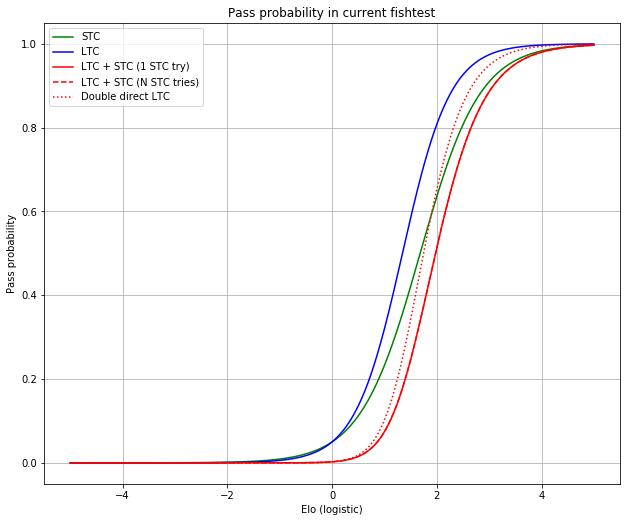

In [7]:
# current pass probabilities
stcvals_now = [stc_now(e) for e in x]
ltcvals_now = [ltc_now(e) for e in x]
combinedvals1_now = [combined_stc_ltc_now(e, 1) for e in x]
combinedvalsN_now = [combined_stc_ltc_now(e, Ntries) for e in x]
doubleDirectvals_now = [ltc_now(e)**2 for e in x]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Pass probability in current fishtest')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('Pass probability')
axes.plot(x, stcvals_now, label = 'STC', color = 'g')
axes.plot(x, ltcvals_now, label = 'LTC', color = 'b')
axes.plot(x, combinedvals1_now, label = 'LTC + STC (1 STC try)', color = 'r')
axes.plot(x, combinedvalsN_now, label = 'LTC + STC (N STC tries)', color = 'r', ls = '--')
axes.plot(x, doubleDirectvals_now, label = 'Double direct LTC', color = 'r', ls = ':')
axes.grid()
axes.legend()

### proposed state (_prop)
Proposed settings, insert proposed bounds here

In [8]:
stc_lower = 1.
stc_upper = 4.
ltc_lower = 0.
ltc_upper = 3.

def stc_prop(x):
    return sprt_pass_prob(x, 226.0, stc_lower, stc_upper, 0.05)

def cost_stc_prop(x):
    return sprt_cost(x, 226.0, stc_lower, stc_upper, 0.05)

def ltc_prop(x):
    return sprt_pass_prob(x, 288.0, ltc_lower, ltc_upper, 0.05)

def cost_ltc_prop(x):
    return 6 * sprt_cost(x, 288.0, ltc_lower, ltc_upper, 0.05)

def combined_stc_ltc_prop(x, ntries):
    stcPass = 0
    for i in range(ntries):
        stcPass = stcPass + stc_prop(x) * (1 - stc_prop(x))**i
    return ltc_prop(x) * stcPass

def cost_combined_stc_ltc_prop(x, ntries):
    stcPass = 0
    for i in range(ntries):
        stcPass = stcPass + stc_prop(x) * (1 - stc_prop(x))**i
    cost_stcPass = 0
    for i in range(ntries):
        cost_stcPass = cost_stcPass + cost_stc_prop(x) * (1 - stc_prop(x))**i
    return cost_ltc_prop(x) * stcPass + cost_stcPass

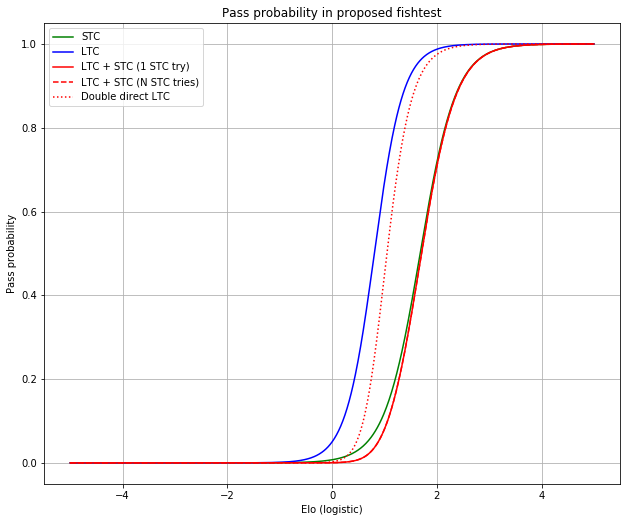

In [9]:
# proposed scheme pass probability
stcvals_prop = [stc_prop(e) for e in x]
ltcvals_prop = [ltc_prop(e) for e in x]
combinedvals1_prop = [combined_stc_ltc_prop(e, 1) for e in x]
combinedvalsN_prop = [combined_stc_ltc_prop(e, Ntries) for e in x]
doubleDirectvals_prop = [ltc_prop(e)**2 for e in x]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Pass probability in proposed fishtest')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('Pass probability')
axes.plot(x, stcvals_prop, label = 'STC', color = 'g')
axes.plot(x, ltcvals_prop, label = 'LTC', color = 'b')
axes.plot(x, combinedvals1_prop, label = 'LTC + STC (1 STC try)', color = 'r')
axes.plot(x, combinedvalsN_prop, label = 'LTC + STC (N STC tries)', color = 'r', ls = '--')
axes.plot(x, doubleDirectvals_prop, label = 'Double direct LTC', color = 'r', ls = ':')
axes.grid()
axes.legend()

## Comparison current vs. proposed

Direct comparision with the current and proposed, for pass probabilities, cost, and most importantly on the distribution of patches that passes testing.

### pass probabilities

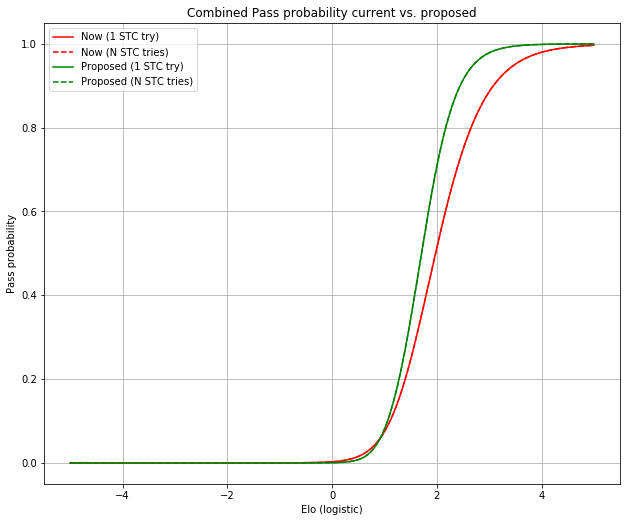

In [10]:
fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Combined Pass probability current vs. proposed')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('Pass probability')
axes.plot(x, combinedvals1_now, label = 'Now (1 STC try)', color = 'r')
axes.plot(x, combinedvalsN_now, label = 'Now (N STC tries)', color = 'r', ls = '--')
axes.plot(x, combinedvals1_prop, label = 'Proposed (1 STC try)', color = 'g')
axes.plot(x, combinedvalsN_prop, label = 'Proposed (N STC tries)', color = 'g', ls = '--')
axes.grid()
axes.legend()

### Patch testing cost

#### base case
Expected cost of testing a patch of x Elo, at STC, LTC, and most relevant LTC after passing STC with up to Ntries tries.

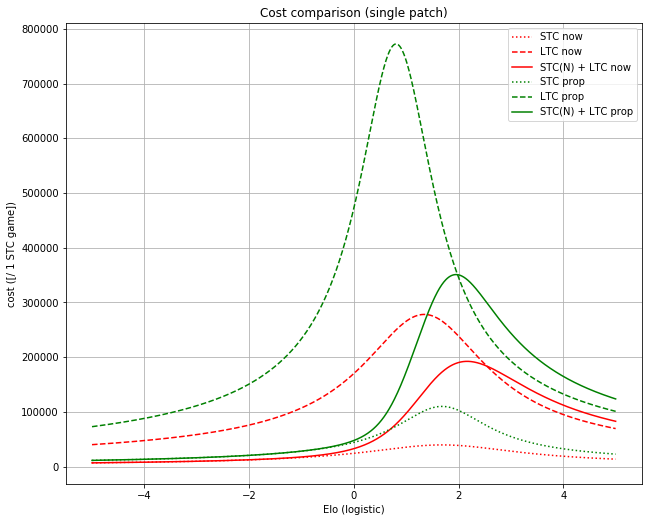

In [11]:
stccostvals_now = [cost_stc_now(e) for e in x]
ltccostvals_now = [cost_ltc_now(e) for e in x]
combinedcostvalsN_now = [cost_combined_stc_ltc_now(e, Ntries) for e in x]

stccostvals_prop = [cost_stc_prop(e) for e in x]
ltccostvals_prop = [cost_ltc_prop(e) for e in x]
combinedcostvalsN_prop = [cost_combined_stc_ltc_prop(e, Ntries) for e in x]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Cost comparison (single patch)')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('cost ([/ 1 STC game])')

axes.plot(x, stccostvals_now, label = 'STC now', color = 'r', ls = ':')
axes.plot(x, ltccostvals_now, label = 'LTC now', color = 'r', ls = '--')
axes.plot(x, combinedcostvalsN_now, label = 'STC(N) + LTC now', color = 'r')

axes.plot(x, stccostvals_prop, label = 'STC prop', color = 'g', ls = ':')
axes.plot(x, ltccostvals_prop, label = 'LTC prop', color = 'g', ls = '--')
axes.plot(x, combinedcostvalsN_prop, label = 'STC(N) + LTC prop', color = 'g')
axes.grid()
axes.legend()

#### expected fraction of time spent in testing patches
Expected cost of testing patch of x Elo, adjust for their frequency, at STC, LTC, and most relevant LTC after passing STC with up to Ntries tries.

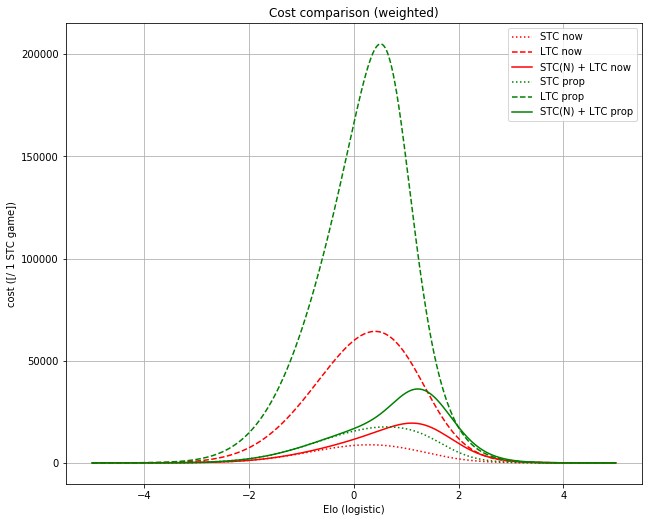

In [12]:
stccostvals_now = [patch_elo_dist(e)*cost_stc_now(e) for e in x]
ltccostvals_now = [patch_elo_dist(e)*cost_ltc_now(e) for e in x]
combinedcostvalsN_now = [patch_elo_dist(e)*cost_combined_stc_ltc_now(e, Ntries) for e in x]

stccostvals_prop = [patch_elo_dist(e)*cost_stc_prop(e) for e in x]
ltccostvals_prop = [patch_elo_dist(e)*cost_ltc_prop(e) for e in x]
combinedcostvalsN_prop = [patch_elo_dist(e)*cost_combined_stc_ltc_prop(e, Ntries) for e in x]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Cost comparison (weighted)')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('cost ([/ 1 STC game])')

axes.plot(x, stccostvals_now, label = 'STC now', color = 'r', ls = ':')
axes.plot(x, ltccostvals_now, label = 'LTC now', color = 'r', ls = '--')
axes.plot(x, combinedcostvalsN_now, label = 'STC(N) + LTC now', color = 'r')

axes.plot(x, stccostvals_prop, label = 'STC prop', color = 'g', ls = ':')
axes.plot(x, ltccostvals_prop, label = 'LTC prop', color = 'g', ls = '--')
axes.plot(x, combinedcostvalsN_prop, label = 'STC(N) + LTC prop', color = 'g')
axes.grid()
axes.legend()

## Influence of testing on patch distribution

Finally, visualize the effect of testing on the orginal patch distribution. This answers the question 'what are the properties of the patches applied, given the original distribution of patches before testing?'.

### without elo weighting.
surface under the graph (computed below) is proportional to the number of applied patches

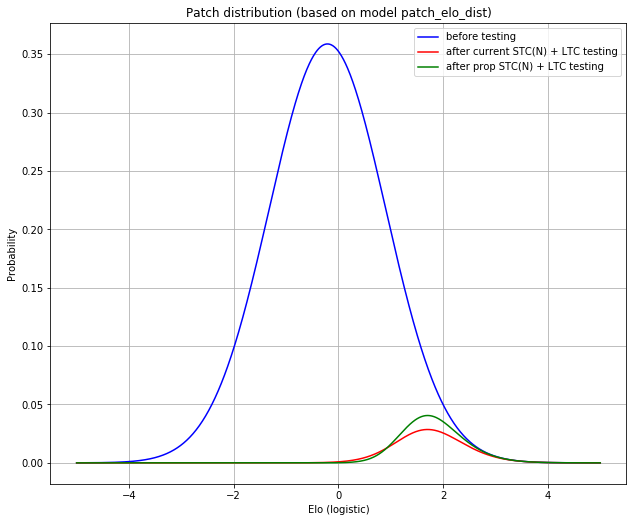

In [13]:
patchelovals = [patch_elo_dist(e) for e in x]
patchelovals_now = [patch_elo_dist(e)*combined_stc_ltc_now(e, Ntries) for e in x]
patchelovals_prop = [patch_elo_dist(e)*combined_stc_ltc_prop(e, Ntries) for e in x]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Patch distribution (based on model patch_elo_dist)')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('Probability')
axes.plot(x, patchelovals, label = 'before testing', color = 'b')
axes.plot(x, patchelovals_now, label = 'after current STC(N) + LTC testing', color = 'r')
axes.plot(x, patchelovals_prop, label = 'after prop STC(N) + LTC testing', color = 'g')
axes.grid()
axes.legend()

### with elo weighting
surface under the graph (computed below) is elo contribution to the code

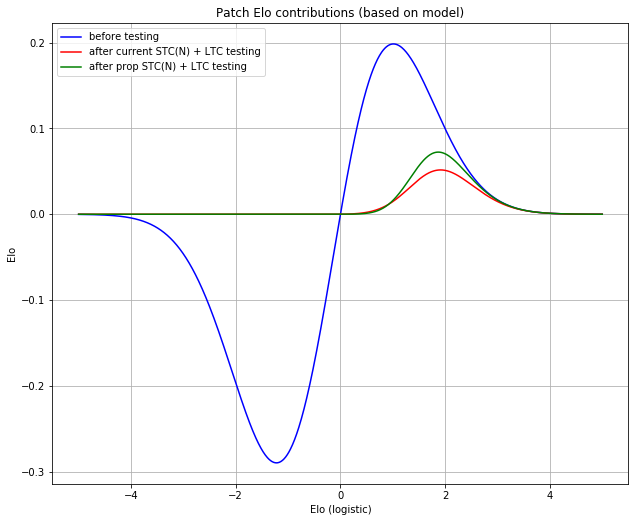

In [14]:
epatchelovals = [e*patch_elo_dist(e) for e in x]
epatchelovals_now = [e*patch_elo_dist(e)*combined_stc_ltc_now(e, Ntries) for e in x]
epatchelovals_prop = [e*patch_elo_dist(e)*combined_stc_ltc_prop(e, Ntries) for e in x]

fig = plt.figure(figsize=(10, 8))
axes = fig.add_axes([0,0,0.8,0.8])
axes.set_title('Patch Elo contributions (based on model)')
axes.set_xlabel('Elo (logistic)')
axes.set_ylabel('Elo')
axes.plot(x, epatchelovals, label = 'before testing', color = 'b')
axes.plot(x, epatchelovals_now, label = 'after current STC(N) + LTC testing', color = 'r')
axes.plot(x, epatchelovals_prop, label = 'after prop STC(N) + LTC testing', color = 'g')
axes.grid()
axes.legend()

### Summary statistics

#### Fraction of patches that pass testing

In [15]:
sum(patchelovals_now) / sum(patchelovals) # Fraction of patches (out of shown range) applied (currently)

0.04659942469820259

In [16]:
sum(patchelovals_prop) / sum(patchelovals) # Fraction of patches (out of shown range) applied (proposed)

0.05762071676293277

In [17]:
sum(patchelovals_prop) / sum(patchelovals_now) # ratio of the number of patches applied

1.2365113332644915

#### pass probability ratios for 0, 1 and 2 Elo patches
assuming 5 tries at STC

In [18]:
combined_stc_ltc_prop(0.0, 5) / combined_stc_ltc_now(0.0, 5) # 0 Elo pass prob ratio

0.15981868569261556

In [19]:
combined_stc_ltc_prop(1.0, 5) / combined_stc_ltc_now(1.0, 5) # 1 Elo pass prob ratio

1.3492599755101955

In [20]:
combined_stc_ltc_prop(2.0, 5) / combined_stc_ltc_now(2.0, 5) # 2 Elo pass prob ratio

1.2278448437822465

#### Elo gain of accepted patches

In [21]:
sum(epatchelovals_now) * dx # Elo fraction accepted now

0.0818593214222428

In [22]:
sum(epatchelovals_prop) * dx # Elo fraction accepted proposal

0.10431736878240665

In [23]:
sum(epatchelovals_prop) / sum(epatchelovals_now) # ratio of elo gain

1.2743492979171163

#### Cost estimate
(cost ratio for testing in the shown range)

In [24]:
sum(combinedcostvalsN_prop) / sum(combinedcostvalsN_now) # ratio of cost

1.6852849602172693

### Table 
as requested in https://github.com/official-stockfish/Stockfish/issues/1859

In [25]:
combined_stc_ltc_prop(0.0, Ntries) # 0 Elo pass prob for Ntries STC try


0.0003668179346449439

In [26]:
combined_stc_ltc_prop(1.0, Ntries) # 1 Elo pass prob for Ntries STC try

0.08051857236856651

In [27]:
# fraction of patches more than 1 elo that is being rejected
1-np.ma.masked_array(patchelovals_prop, ~(x>1)).sum() / np.ma.masked_array(patchelovals, ~(x>1)).sum()

0.6133242770965559

In [28]:
# fraction of patches less than 0 elo that pass
np.ma.masked_array(patchelovals_prop, ~(x<0)).sum() / np.ma.masked_array(patchelovals, ~(x<0)).sum()

3.51932434170965e-05

In [29]:
# average STC cost (in games)
sum(stccostvals_prop) * dx

47822.00751236398

In [30]:
# average STC + LTC cost 
sum(combinedcostvalsN_prop) * dx

80060.4348213669